In [1]:
from download import *
from databuilder import *
from dataset import *
from processing import *

from torchvision import transforms
import torch.nn as nn

from ResNet import resnet
from MobileNet import MobileNetV2
from EfficientNet import efficientnet

import funcs

df = download_mimii("../../../data/mimii", "0_dB")

../../../data/mimii/0_dB/fan.zip already exist.
../../../data/mimii/0_dB/fan.zip already extracted.
../../../data/mimii/0_dB/pump.zip already exist.
../../../data/mimii/0_dB/pump.zip already extracted.
../../../data/mimii/0_dB/slider.zip already exist.
../../../data/mimii/0_dB/slider.zip already extracted.
../../../data/mimii/0_dB/valve.zip already exist.
../../../data/mimii/0_dB/valve.zip already extracted.


In [2]:
params = {
    "batch_size":32,
    "epoch": 5,
    "learning_rate": 0.0001,
    "path": "./saved/efficientnet/ephoc5"
}

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [3]:
# df["label"].value_counts()
df["label"].value_counts().sort_index()

0    14719
1     1475
2      456
3      890
4      479
Name: label, dtype: int64

In [4]:
train_df, val_df, test_df = split_dataframe(df)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(8263, 2)
(5507, 2)
(4249, 2)


In [5]:
train_data, train_label = build_from_dataframe(train_df, 4096, 4096//2, False)
val_data, val_label = build_from_dataframe(val_df, 4096, 4096//2, False)
test_data, test_label = build_from_dataframe(test_df, 4096, 4096//2, False)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(636251, 4096)
(424039, 4096)
(327173, 4096)


In [6]:
transform = transforms.Compose([
    melspectogram(),
    ExpandDim(),
    # ReSize(3, 32, 32),
    NpToTensor()
])

In [7]:
train_dataset = NumpyDataset(data=train_data, label=train_label, 
                             transform=transform, target_transform=NpToTensor())
val_dataset = NumpyDataset(data=val_data, label=val_label, 
                             transform=transform, target_transform=NpToTensor())
test_dataset = NumpyDataset(data=test_data, label=test_label, 
                             transform=transform, target_transform=NpToTensor())

# print(train_dataset.data)
# print(train_dataset.label)

In [8]:
train_loader = get_dataloader(dataset=train_dataset,
                              batch_size=params["batch_size"],
                              shuffle=True)
val_loader = get_dataloader(dataset=val_dataset,
                              batch_size=params["batch_size"],
                              shuffle=False)
test_loader = get_dataloader(dataset=test_dataset,
                              batch_size=params["batch_size"],
                              shuffle=False)

In [9]:
# # 데이터로더 동작 확인
for i, (data, target) in enumerate(train_loader):
    print(i, data.shape, target.shape)
    if i > 9:
        break

0 torch.Size([32, 1, 128, 5]) torch.Size([32])
1 torch.Size([32, 1, 128, 5]) torch.Size([32])
2 torch.Size([32, 1, 128, 5]) torch.Size([32])
3 torch.Size([32, 1, 128, 5]) torch.Size([32])
4 torch.Size([32, 1, 128, 5]) torch.Size([32])
5 torch.Size([32, 1, 128, 5]) torch.Size([32])
6 torch.Size([32, 1, 128, 5]) torch.Size([32])
7 torch.Size([32, 1, 128, 5]) torch.Size([32])
8 torch.Size([32, 1, 128, 5]) torch.Size([32])
9 torch.Size([32, 1, 128, 5]) torch.Size([32])
10 torch.Size([32, 1, 128, 5]) torch.Size([32])


In [10]:
model = efficientnet().EfficientNetb0(num_classes=5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

In [11]:
train_acc_list = []
train_loss_list = []

test_acc_list = []
test_loss_list = []

In [12]:
for epoch in range(1, params["epoch"] + 1):
    train_loss, train_accuracy = funcs.train(model, train_loader, optimizer, DEVICE, criterion, params["batch_size"])
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    print("[EPOCH: {}] \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy))

    test_loss, test_accuracy = funcs.test(model, test_loader, DEVICE, criterion, params["batch_size"])
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    print("[EPOCH: {}] \tTest Loss: {:.4f}, \tTest Accuracy: {:.4f}\n".format(
        epoch, test_loss, test_accuracy))
    # 에폭당 학습률 확인(필요시)
    # l_r = [x["lr"] for x in optimizer.param_groups]
    # print("lr:{}\n".format(l_r))


[EPOCH: 1] 	Train Loss: 0.1172, 	Train Accuracy: 0.9595
[EPOCH: 1] 	Test Loss: 1.1383, 	Test Accuracy: 0.6917

[EPOCH: 2] 	Train Loss: 0.0497, 	Train Accuracy: 0.9822
[EPOCH: 2] 	Test Loss: 1.0379, 	Test Accuracy: 0.7388

[EPOCH: 3] 	Train Loss: 0.0410, 	Train Accuracy: 0.9850
[EPOCH: 3] 	Test Loss: 0.9346, 	Test Accuracy: 0.7346

[EPOCH: 4] 	Train Loss: 0.0367, 	Train Accuracy: 0.9865
[EPOCH: 4] 	Test Loss: 1.1323, 	Test Accuracy: 0.7036

[EPOCH: 5] 	Train Loss: 0.0337, 	Train Accuracy: 0.9874
[EPOCH: 5] 	Test Loss: 1.2685, 	Test Accuracy: 0.6625



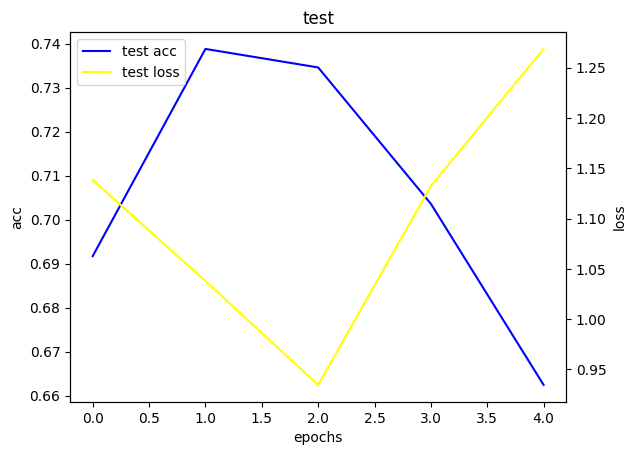

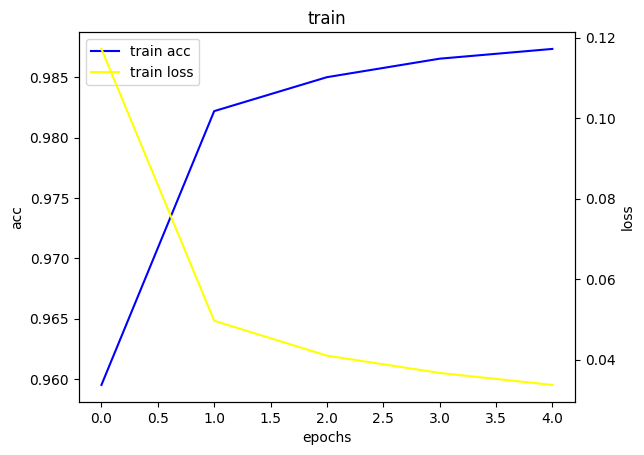

In [13]:
funcs.DrawGraph(test_acc_list, test_loss_list, 'test', mode='test', root=params["path"])
funcs.DrawGraph(train_acc_list, train_loss_list, 'train', mode='train', root=params["path"])

In [14]:
max_test_acc = max(test_acc_list)
print('max_test_acc: ', max_test_acc)

max_test_acc:  0.7387742876093076


In [15]:
# 모델 저장
torch.save(model.state_dict(), f"{params['path']}/model.pth")